In [1]:
# required modules (skip if already installed)
if False:
    !pip install pyroaring
    !pip install pyfim 
    # if previous does not work, try: !conda install -c conda-forge pyfim
    !pip install lightgbm
    !pip install fairlearn

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# global imports
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# local imports
sys.path.append('../src/') # local path
import dd

# general settings  
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=10)
plt.rc('legend', fontsize=10)
plt.rc('lines', linewidth=2)
plt.rc('axes', linewidth=2)
plt.rc('axes', edgecolor='k')
plt.rc('xtick.major', width=2)
plt.rc('xtick.major', size=6)
plt.rc('ytick.major', width=2)
plt.rc('ytick.major', size=6)
plt.rc('pdf', fonttype=42)
plt.rc('ps', fonttype=42)

In [3]:
# read ACSIncome data
df, decode = pickle.load(open('../data/ACSIncome.pckl', 'rb'))
# sample
if True:
    df = df.sample(frac=0.2)
# state names
states = decode['STATE'].values()
# pretty printing long labels
pretty_rac1p = ['White', 'Black', 'Indian', 'Alaskian', 'Alaskian-Indian', 'Asian', 'Hawaiian', 'Other', 'Two+']
decode['RAC1P'] = { (i+1):pretty_rac1p[i] for i in range(len(pretty_rac1p)) }
# change to True to binarize RAC1P
if False: 
    census["RAC1P"][census["RAC1P"]!='White'] = 'Not White'

In [4]:
# there are no missing values
df.isna().sum()

AGEP         0
COW          0
SCHL         0
MAR          0
OCCP         0
POBP         0
WKHP         0
SEX          0
RAC1P        0
STATE        0
class        0
AGEPgroup    0
OCCPgroup    0
POBPgroup    0
WKHPgroup    0
dtype: int64

In [5]:
df.head()

,AGEP,COW,SCHL,MAR,OCCP,POBP,WKHP,SEX,RAC1P,STATE,class,AGEPgroup,OCCPgroup,POBPgroup,WKHPgroup
1295045,46,8,21,1,4700,42,45,2,1,37,0,2,16,0,4
604264,44,1,20,1,7330,19,60,1,1,14,1,2,21,0,4
1397217,45,1,21,1,705,210,50,1,6,42,1,2,1,2,4
1002658,50,2,16,5,5240,36,30,1,1,31,0,2,17,0,2
1657152,67,1,21,5,5740,72,40,2,1,50,0,4,17,0,3


In [6]:
decode

{'COW': {1: 'Employee of a private for-profit company orbusiness, or of an individual, for wages,salary, or commissions',
  2: 'Employee of a private not-for-profit, tax-exempt,or charitable organization',
  3: 'Local government employee (city, county, etc.)',
  4: 'State government employee',
  5: 'Federal government employee',
  6: 'Self-employed in own not incorporated business,professional practice, or farm',
  7: 'Self-employed in own incorporated business,professional practice or farm',
  8: 'Working without pay in family business or farm',
  9: 'Unemployed and last worked 5 years ago or earlier or never worked'},
 'SCHL': {1: 'No schooling completed',
  2: 'Nursery school, preschool',
  3: 'Kindergarten',
  4: 'Grade 1',
  5: 'Grade 2',
  6: 'Grade 3',
  7: 'Grade 4',
  8: 'Grade 5',
  9: 'Grade 6',
  10: 'Grade 7',
  11: 'Grade 8',
  12: 'Grade 9',
  13: 'Grade 10',
  14: 'Grade 11',
  15: '12th grade - no diploma',
  16: 'Regular high school diploma',
  17: 'GED or alternative

In [15]:
# predictive attributes (for models)
pred_atts = ['AGEP', 'COW', 'SCHL', 'MAR', 'OCCPgroup', 'POBPgroup', 'WKHP', 'SEX', 'RAC1P', 'STATE']
pred_all = pred_atts + ['class']
# nominal-ordinal-continuous partition of predictive attributes (for DD)
nominal_atts = ['COW', 'MAR', 'OCCPgroup', 'POBPgroup', 'SEX', 'RAC1P', 'STATE']
ordinal_atts = ['SCHL']
df[ordinal_atts] = df[ordinal_atts].astype(int)
continuous_atts = ['AGEP', 'WKHP']

# split train test
X = df[pred_atts]
y = df['class'].astype(int)
X_train, X_test, y_train, y_test, df_train, df_test = train_test_split(X, y, df, test_size=0.33, random_state=42)

In [16]:
X_train.info(), len(X_test)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 223043 entries, 156596 to 432037
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   AGEP       223043 non-null  int32   
 1   COW        223043 non-null  category
 2   SCHL       223043 non-null  int32   
 3   MAR        223043 non-null  category
 4   OCCPgroup  223043 non-null  category
 5   POBPgroup  223043 non-null  category
 6   WKHP       223043 non-null  int32   
 7   SEX        223043 non-null  category
 8   RAC1P      223043 non-null  category
 9   STATE      223043 non-null  category
dtypes: category(7), int32(3)
memory usage: 5.7 MB


(None, 109857)

In [17]:
# training model and make predictions - lightgbm able to deal with categorial attributes
import lightgbm as lgb

clf = lgb.LGBMClassifier(random_state=42)
clf.fit(X_train, y_train)
# add predicted class in the adult_test (decoding back)
y_pred_b = clf.predict(X_test)
y_score_b = clf.predict_proba(X_test)[:,1]
df_test['pred_b'] = y_pred_b
df_test['score_b'] = y_score_b
decode['pred_b'] = decode['class']
df_test.head()

,AGEP,COW,SCHL,MAR,OCCP,POBP,WKHP,SEX,RAC1P,STATE,class,AGEPgroup,OCCPgroup,POBPgroup,WKHPgroup,pred_b,score_b
229802,45,4,16,3,3602,207,15,2,6,4,0,2,11,2,1,0,0.017182
508454,30,1,24,5,3250,17,55,1,1,12,1,0,10,0,4,1,0.862259
1398432,50,7,19,5,9142,48,40,1,8,42,0,2,23,0,3,0,0.222737
539014,37,1,21,1,1021,25,55,1,1,12,1,1,3,0,4,1,0.949113
1434464,74,1,21,1,10,42,30,1,1,42,1,4,0,0,2,1,0.771086


In [52]:
import heapq

class distFunctions:
    """ TBD """
    def __init__(self, df_train, nominal_atts=[], continuous_atts=[], ordinal_atts=[]):
        self.nominal_atts = nominal_atts
        self.continuous_atts = continuous_atts
        self.ordinal_atts = ordinal_atts
        self.means = { c:df_train[c].mean() for c in continuous_atts }
        self.stds = { c:df_train[c].std() for c in continuous_atts }
        self.nofvalues = { c:(df_train[c].nunique()-1) for c in ordinal_atts }
        self.natts = len(continuous_atts)+len(nominal_atts)+len(ordinal_atts)
        cols = list(df_train.columns)
        self.nominal_atts_pos = [cols.index(c) for c in nominal_atts]
        self.continuous_atts_pos = [cols.index(c) for c in continuous_atts]
        self.ordinal_atts_pos = [cols.index(c) for c in ordinal_atts]
        self.stds_pos = { self.continuous_atts_pos[i]:self.stds[c] for i, c in enumerate(continuous_atts) }
        self.nofvalues_pos = { self.ordinal_atts_pos[i]:self.nofvalues[c] for i, c in enumerate(ordinal_atts) }
              
    def kdd2011dist(self, t1, tset):
        tot = np.zeros(len(tset)) if isinstance(tset, pd.DataFrame) else 0
        for c in self.continuous_atts:
            tot += abs(t1[c]-tset[c])/self.stds[c]
        for c in self.nominal_atts:
            tot += 1*(t1[c]!=tset[c])
        for c in self.ordinal_atts:
            tot += abs(t1[c]-tset[c])/self.nofvalues[c]
        return tot/self.natts
    
    def topk(self, t, tset, distf, k, maxd=None):
        ds = distf(t, tset)
        q = []
        lenq = 0
        for i, d in zip(tset.index, ds):
            if maxd is None or d <= maxd:
                if lenq < k:
                    heapq.heappush(q, (-d, i))
                    lenq += 1
                else:
                    d1, _ = heapq.heappushpop(q, (-d, i))
                    maxd = -d1
        q = [(-v, i) for v, i in q]
        return sorted(q)

dist = distFunctions(df_train, nominal_atts, continuous_atts, ordinal_atts)

In [41]:
# settings
sens_att = 'RAC1P'
unpro = 1 # White, see decode['RAC1P']
unpro_set = df_test[df_test[sens_att]==unpro]
print('Unprotected', decode['RAC1P'][unpro], 'No instances', len(unpro_set))
k = 5

Unprotected White No instances 85904


In [99]:
%%time
df_test['RD'] = 0.0
for pro in df_test[sens_att].unique():
    if pro==unpro:
        continue
    pro_set = df_test[df_test[sens_att]==pro]
    print('Protected', decode['RAC1P'][pro], 'No instances', len(pro_set))
    for i, rowp in pro_set.iterrows():
        res1 = dist.topk(rowp, pro_set, dist.kdd2011dist, k+1)
        res2 = dist.topk(rowp, unpro_set.sample(1000), dist.kdd2011dist, k)
        nn1 = [j for _, j in res1 if j != i]
        nn2 = [j for _, j in res2]
        # efficient but specific of RD
        p1 = sum(df_test.loc[nn1,'pred_b']==0)/len(nn1)
        p2 = sum(df_test.loc[nn2,'pred_b']==0)/len(nn2)
        df_test.loc[i, 'RD'] = p1-p2
        #print('RD', p1-p2)
       
        '''
        # inefficient but general
        tmpdf = df_test.loc[nn1+nn2,:]
        print(i, pro_set.loc[i,:])
        print(tmpdf)
        disc_b = dd.DD(tmpdf[['RAC1P', 'class', 'pred_b']], unprotectedItem='RAC1P=White', 
               predBadItem='pred_b=<=50K', trueBadItem='class=<=50K', valuedecode=decode)
        ctg = disc_b.ctg_any()
        disc_b.print(ctg)
        print('RD', ctg.rd())
        '''
        #break
        if i % 1000 == 0:
            print(i)
    #break

Protected Asian No instances 6255
268000
229000
1010000
1505000
265000
892000
234000
198000
Protected Other No instances 4113
997000
60000
1111000
Protected Black No instances 9708
514000
1083000
505000
473000
1619000
427000
918000
1358000
753000
Protected Indian No instances 756
1206000
Protected Two+ No instances 2744
390000
142000
1530000
190000
482000
480000
158000
Protected Hawaiian No instances 183
146000
Protected Alaskian-Indian No instances 145
Protected Alaskian No instances 49
CPU times: total: 5min 41s
Wall time: 5min 42s


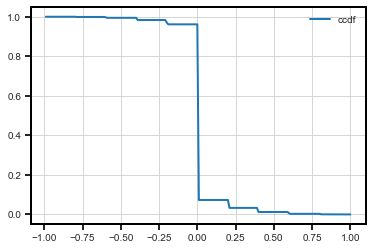

In [114]:
values = df_test[df_test[sens_att]!=pro]['RD']
count, bins_count = np.histogram(values, bins=200)
cdf = np.cumsum(count) / sum(count)
ccdf = 1 - cdf
#plt.plot(bins_count[1:], cdf, label='cdf')
plt.plot(bins_count[1:], ccdf, label='ccdf')
plt.legend()
plt.show()


In [31]:
%%time
from sklearn.neighbors import NearestNeighbors

nbrs_unpro = NearestNeighbors(n_neighbors=k, algorithm='ball_tree', metric=dist.kdd2011dist).fit(unpro_set.sample(1000)) # , metric=dist.knndist
for pro in decode['RAC1P'].keys():
    if pro==unpro:
        continue
    pro_set = df_test[df_test[sens_att]==pro]
    print('Protected', decode['RAC1P'][pro], 'No instances', len(pro_set))
    distances, indices = nbrs_unpro.kneighbors(pro_set)
    nbrs_pro = NearestNeighbors(n_neighbors=k, algorithm='ball_tree', metric=dist.kdd2011dist).fit(pro_set) 
    distances, indices = nbrs_pro.kneighbors(pro_set)
    if i % 1000 == 0:
        print(i)

Protected Black No instances 9708


KeyboardInterrupt: 

In [ ]:
%%time
from sklearn.neighbors import NearestNeighbors
from distython import HEOM

sens_att = 'RAC1P'
unpro = 1 # White, see decode['RAC1P']
unpro_set = dfn[dfn[sens_att]==unpro]
k = 5
# Declare the HEOM with a correct NaN equivalent value
heom_metric = HEOM(unpro_set, dist.nominal_atts_pos)

nbrs_unpro = NearestNeighbors(n_neighbors=k, algorithm='ball_tree', metric=heom_metric.heom).fit(unpro_set) # , metric=dist.knndist
for pro in decode['RAC1P'].keys():
    if pro==unpro:
        continue
    pro_set = dfn[dfn[sens_att]==pro]
    distances, indices = nbrs_unpro.kneighbors(pro_set)
    break



### Independence metrics: how much discrimination in the predictions?

In [ ]:
# DD(filename or dataframe, unprotectedItem, predBadItem)
disc_b = dd.DD(df_test[disc_all+['pred_b']], unprotectedItem='RAC1P=White', predBadItem='pred_b=<=50K', valuedecode=decode)    
# all protected vs unprotected
ctg = disc_b.ctg_any()
disc_b.print(ctg)
print("RD = {:f}".format(ctg.rd()))
# each protected vs unprotected
for ctg in disc_b.ctg_global():
    disc_b.print(ctg)
    print("RD = {:f}".format(ctg.rd()))

### Independence metrics: how much discrimination in the ground truth (perfect model)?

In [ ]:
# DD(filename or dataframe, unprotectedItem, predBadItem)
disc_gt = dd.DD(df_test[disc_all], unprotectedItem='RAC1P=White', predBadItem='class=<=50K', valuedecode=decode)   
# all protected vs unprotected
ctg = disc_gt.ctg_any()
disc_gt.print(ctg)
print("RD = {:f}".format(ctg.rd()))
# each protected vs unprotected
for ctg in disc_gt.ctg_global():
    disc_gt.print(ctg)
    print("RD = {:f}".format(ctg.rd()))

In [ ]:
m_gt = dict()
m_b = dict()
for ctg in disc_gt.ctg_global():
    _, pr = disc_gt.ctg_info(ctg)
    pro = dd.get_val(pr)
    m_gt[pro] = ctg.rd()
    m_b[pro] = disc_b.ctg_rel(ctg).rd()

In [ ]:
sorted_rac1p = sorted(pretty_rac1p[1:]) # White removed
X_axis = np.arange(len(sorted_rac1p))
plt.bar(X_axis - 0.2, [m_b[pro] for pro in sorted_rac1p], 0.4, label='RD classifier')
plt.bar(X_axis + 0.2, [m_gt[pro] for pro in sorted_rac1p], 0.4, label='RD oracle')
plt.xticks(X_axis, sorted_rac1p)
plt.xticks(rotation=90)
plt.legend()
plt.ylabel("RD", fontweight="bold")
plt.show()

### Independence metrics: discovering discrimination in predictions

In [ ]:
# filtering condition: return None to filter out, or measure value
# contingency table ctg such that ctg.n() >= minSupp 
'''
     contingency table for independence
     =========== pred.bad === pred.good === 
     protected       a            b       n1()
     unprotected     c            d       n2()
     ===========    m1()  ===    m2()  ==  n()
'''
def check_rd(ctg):
    # at least 20 protected
    return ctg.rd() if ctg.a >= 20 and ctg.n2() > 0 else None

def check_rr(ctg):
    # at least 20 protected 
    return ctg.rr() if ctg.a >= 20 and ctg.n2() > 0 else None

In [ ]:
# Extract contingency tables: 
# minSupp = min support of context (negative = absolute, positive = percentage)
# topk = top k contingency tables
ctgs_rd = disc_b.extract(testCond=check_rd, minSupp=-100, topk=1000)
ctgs_rr = disc_b.extract(testCond=check_rr, minSupp=-100, topk=1000)

In [ ]:
# top 3 wrt RD
for v, ctg in ctgs_rd[:3]:
    disc_b.print(ctg)
    print("RD = {:f}".format(v))

In [ ]:
# top 3 wrt RR
for v, ctg in ctgs_rr[:3]:
    disc_b.print(ctg)
    print("RR = {:f}".format(v))

In [ ]:
# contingency tables in ctgs_rd
ct_rd_set = set(ctg[1] for ctg in ctgs_rd)
# contingency tables in ctgs_rd
ct_rr_set = set(ctg[1] for ctg in ctgs_rr)
# contingency tables in both
shared = ct_rd_set & ct_rr_set
len(shared) 

In [ ]:
# plot p1() vs p2() for top-k contingency tables
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot([ctg.p1() for ctg in shared], [ctg.p2() for ctg in shared], '+', color='red', label=r'RR $\cap$ RD')
only_rd = ct_rd_set - shared
plt.plot([ctg.p1() for ctg in only_rd], [ctg.p2() for ctg in only_rd], '.', color='blue', label=r'RD \ RR')
only_rr = ct_rr_set - shared
plt.plot([ctg.p1() for ctg in only_rr], [ctg.p2() for ctg in only_rr], 'x', color='green', label=r'RR \ RD')
plt.legend()
plt.xlabel('p1')
plt.ylabel('p2')

### Independence metrics: fair-classifier

In [ ]:
# Fairlearn algorithms and utils (https://github.com/fairlearn/fairlearn)
# or try your preferred fair ML tool
from fairlearn.postprocessing import ThresholdOptimizer
# fairness by post-processing
postprocess_est = ThresholdOptimizer(estimator=clf, constraints="demographic_parity", prefit=True, predict_method='predict')
postprocess_est.fit(X_train, y_train, sensitive_features=X_train['RAC1P'])
# fair-corrected predictions 
y_pred_a = postprocess_est.predict(X_test, sensitive_features=X_test['RAC1P'], random_state=42).astype(int)
df_test['pred_a'] = y_pred_a
# extend decode
decode['pred_a'] = decode['class']

In [ ]:
# DD(filename or dataframe, unprotectedItem, predBadItem)
disc_a = dd.DD(df_test[disc_all+['pred_a']], unprotectedItem='RAC1P=White', predBadItem='pred_a=<=50K', valuedecode=decode)  
# all protected vs unprotected
ctg = disc_a.ctg_any()
disc_b.print(ctg)
print("RD = {:f}".format(ctg.rd()))
# each protected vs unprotected
for ctg in disc_a.ctg_global():
    disc_a.print(ctg)
    print("RD = {:f}".format(ctg.rd()))

In [ ]:
m_a = dict()
for ctg in disc_a.ctg_global():
    _, pr = disc_a.ctg_info(ctg)
    pro = dd.get_val(pr)
    m_a[pro] = ctg.rd()

In [ ]:
sorted_rac1p = sorted(pretty_rac1p[1:]) # White removed
X_axis = np.arange(len(sorted_rac1p))
plt.bar(X_axis - 0.45, [m_b[pro] for pro in sorted_rac1p], 0.3, label='RD classifier')
plt.bar(X_axis - 0.15, [m_gt[pro] for pro in sorted_rac1p], 0.3, label='RD oracle')
plt.bar(X_axis + 0.15, [m_a[pro] for pro in sorted_rac1p], 0.3, label='RD corrected')
plt.xticks(X_axis, sorted_rac1p)
plt.xticks(rotation=90)
plt.legend()
plt.ylabel("RD", fontweight="bold")
plt.show()

In [ ]:
# compare accuracies
print('ACC classifier', np.mean(y_test == y_pred_b))
print('ACC corrected', np.mean(y_test == y_pred_a))

### Separation metrics: how much discrimination in the predictions?

In [ ]:
# DD(filename or dataframe, unprotectedItem, predBadItem)
disc_b = dd.DD(df_test[disc_all+['pred_b']], unprotectedItem='RAC1P=White', 
               predBadItem='pred_b=<=50K', trueBadItem='class=<=50K', valuedecode=decode)  
# all protected vs unprotected
ctg = disc_b.ctg_any()
disc_b.print(ctg)
print("EOP = {:f}".format(ctg.eop()))
# each protected vs unprotected
for ctg in disc_b.ctg_global():
    disc_b.print(ctg)
    print("EOP = {:f}".format(ctg.eop()))

### Separation metrics: correcting the classifier

In [ ]:
postprocess_est = ThresholdOptimizer(estimator=clf, constraints="true_positive_rate_parity", prefit=True, predict_method='predict')
postprocess_est.fit(X_train, y_train, sensitive_features=X_train['RAC1P'])
# fair-corrected predictions 
y_pred_a = postprocess_est.predict(X_test, sensitive_features=X_test['RAC1P']).astype(int)
df_test['pred_a'] = y_pred_a
# extend decode
decode['pred_a'] = decode['class']

In [ ]:
# DD(filename or dataframe, unprotectedItem, predBadItem)
disc_a = dd.DD(df_test[disc_all+['pred_a']], unprotectedItem='RAC1P=White', 
               predBadItem='pred_a=<=50K', trueBadItem='class=<=50K', valuedecode=decode)      
# all protected vs unprotected
ctg = disc_a.ctg_any()
disc_b.print(ctg)
print("EOP = {:f}".format(ctg.eop()))
# each protected vs unprotected
for ctg in disc_a.ctg_global():
    disc_a.print(ctg)
    print("EOP = {:f}".format(ctg.eop()))

In [ ]:
m_a = dict()
m_b = dict()
for ctg in disc_a.ctg_global():
    _, pr = disc_a.ctg_info(ctg)
    pro = dd.get_val(pr)
    m_a[pro] = ctg.eop()
    m_b[pro] = disc_b.ctg_rel(ctg).eop()

plt.bar(X_axis - 0.2, [m_b[pro] for pro in sorted_rac1p], 0.4, label='EOP classifier')
plt.bar(X_axis + 0.2, [m_a[pro] for pro in sorted_rac1p], 0.4, label='EOP corrected')
plt.xticks(X_axis, pretty_rac1p[:-1])
plt.xticks(rotation=90)
plt.legend()
plt.ylabel("EOP", fontweight="bold")
plt.show()

In [ ]:
# compare accuracies
print('ACC classifier', np.mean(y_test == y_pred_b))
print('ACC corrected', np.mean(y_test == y_pred_a))